## Note
For complete list of descriptors, look at the Rdkit documentation
https://www.rdkit.org/
This notebook only looks at a single conformer for each OSDA. This approach can easily be combined with the conformer calculating script to look at multiple conformers for each molecule.

In [1]:
# change working directory
%cd ..

/home/OSDA_Generator


In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rdkit import Chem
from rdkit.Chem import rdFreeSASA, Descriptors, Descriptors3D, AllChem, Draw

In [6]:
# load data and pca models
data = pd.read_excel('data/Jensen_et_al_CentralScience_OSDA_Zeolite_data.xlsx', engine='openpyxl')
osda_pca = pickle.load(open('models/osda_pca.p', 'rb'))
osda_norm = pickle.load(open('models/osda_normalizer.p', 'rb'))

In [8]:
data.columns

Index(['Unnamed: 0', 'doi', 'orig_sda', 'sda', 'smiles', 'formula', 'itq',
       'sas', 'num_rot', 'asph', 'ecc', 'isf', 'npr1', 'npr2', 'pmi1', 'pmi2',
       'pmi3', 'rog', 'si', 'single_conformer_WHIM', 'Num N', 'Num P',
       'Charge', 'nConf20', 'zeo', 'Code', 'FD', 'max_ring_size',
       'channel_dim', 'inc_diameter', 'inc_vol', 'accvol', 'sec', 'comp',
       'maxarea', 'minarea', 'syn1', 'syn2', 'syn3', 'syn4', 'syn5', 'syn6',
       'syn7', 'syn8', 'avg_vol_conformer_pca_whim',
       'min_vol_conformer_pca_whim', 'all_conformer_pca_whim',
       'avg_vol_conformer_whim', 'min_vol_conformer_whim',
       'all_conformer_whim'],
      dtype='object')

In [19]:
# specify the SMILES strings, can specify a user-defined list, set a path to a pickle file (usually)
# for generated smiles, or calculate from the data set
all_smiles = []
smiles = [] # user specified smiles
path_to_file = '' # path to pickle file containing OSDAs, often from generated OSDAs
if smiles:
    print('Using user defined OSDAs')
    for s in smiles:
        can = Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True)
        if can not in all_smiles:
            all_smiles.append(can)
elif path_to_file != '':
    print('Reading SMILES from', path_to_file)
    curr = pickle.load(open(path_to_file, 'rb'))
    for c in curr:
        can = Chem.MolToSmiles(Chem.MolFromSmiles(c), canonical=True)
        if can not in all_smiles:
            all_smiles.append(can)
else:
    print('Using all SMILES from data set')
    for i, row in data.iterrows():
        if pd.isnull(row['smiles']):
            continue
        else:
            curr = row['smiles'].split(' + ')
            for smile in curr:
                m = Chem.MolFromSmiles(smile)
                if m is not None:
                    can = Chem.MolToSmiles(m, canonical=True)
                    if can not in all_smiles:
                        all_smiles.append(can)
print(len(all_smiles))

Reading SMILES from data/generated_osdas.pickle
21


In [20]:
# Calculate the descriptors
whims, mol_weights, volumes, asphericity, smiles = [],[],[],[],[]
for smile in all_smiles:
    try:
        m = Chem.MolFromSmiles(smile)
        m2 = Chem.AddHs(m)
        AllChem.EmbedMolecule(m2)
        AllChem.MMFFOptimizeMolecule(m2)
        whims.append(Chem.rdMolDescriptors.CalcWHIM(m2))
        mol_weights.append(Descriptors.MolWt(m2))
        volumes.append(AllChem.ComputeMolVolume(m2))
        asphericity.append(Descriptors3D.Asphericity(m2))
        smiles.append(smile)
    except:
        pass
print(len(whims), len(mol_weights), len(volumes), len(asphericity), len(smiles))

21 21 21 21 21


Text(0, 0.5, 'Frequency')

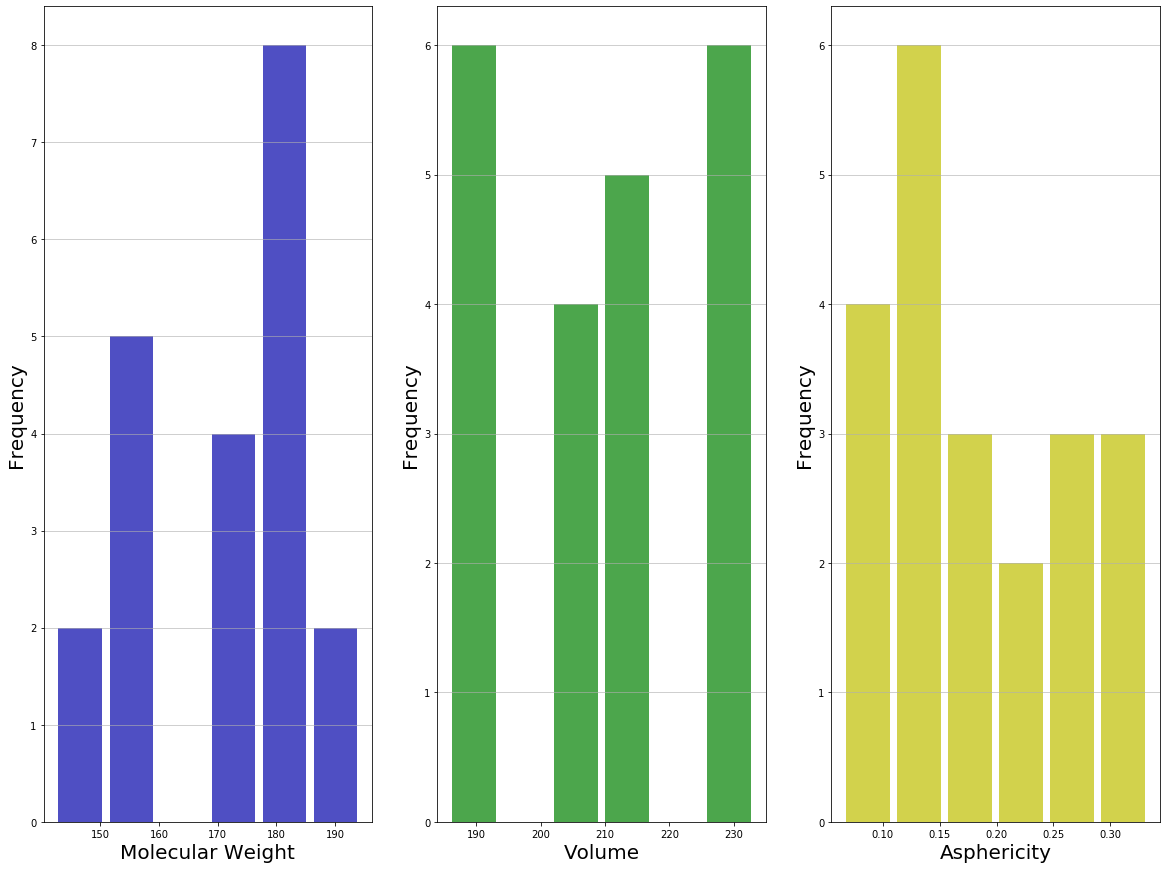

In [21]:
# Visualize the descriptor distributions 
fig, ax = plt.subplots(1,3, figsize=(20,15))
ax[0].hist(x=mol_weights,bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
ax[0].grid(axis='y', alpha=0.75)
ax[0].set_xlabel('Molecular Weight', fontsize=20)
ax[0].set_ylabel('Frequency', fontsize=20)
ax[1].hist(x=volumes,bins='auto', color='g',alpha=0.7, rwidth=0.85)
ax[1].grid(axis='y', alpha=0.75)
ax[1].set_xlabel('Volume', fontsize=20)
ax[1].set_ylabel('Frequency', fontsize=20)
ax[2].hist(x=asphericity,bins='auto', color='y',alpha=0.7, rwidth=0.85)
ax[2].grid(axis='y', alpha=0.75)
ax[2].set_xlabel('Asphericity', fontsize=20)
ax[2].set_ylabel('Frequency', fontsize=20)

In [24]:
# Get all the OSDA WHIMs from the data to compare
lit_osda_whims = []
for i, row in data.iterrows():
    if pd.isnull(row['smiles']):
            continue
    else:
        curr = row['smiles'].split(' + ')
        for smile in curr:
            m = Chem.MolFromSmiles(smile)
            if m is not None:
                can = Chem.MolToSmiles(m, canonical=True)
                if can not in all_smiles:
                    m2 = Chem.AddHs(m)
                    AllChem.EmbedMolecule(m2)
                    try:
                        AllChem.MMFFOptimizeMolecule(m2)
                        lit_osda_whims.append(Chem.rdMolDescriptors.CalcWHIM(m2))
                    except:
                        pass
print(len(lit_osda_whims))

5944


In [25]:
# Reduce dimensionality of WHIM with pretrained PCA model
lit_pca = osda_pca.transform(osda_norm.transform(lit_osda_whims))
curr_pca = osda_pca.transform(osda_norm.transform(whims))

Text(0, 0.5, 'PCA 3')

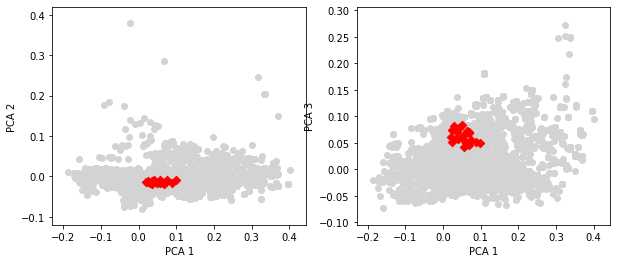

In [26]:
# Visualize the selected OSDAs in reduced WHIM space relative to the literature OSDAs
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(lit_pca[:,0], lit_pca[:,1], c='lightgrey', label='Literature')
ax[0].scatter(curr_pca[:,0], curr_pca[:,1], c='r', marker='D', label='Selected')
ax[0].set_xlabel('PCA 1')
ax[0].set_ylabel('PCA 2')
ax[1].scatter(lit_pca[:,0], lit_pca[:,2], c='lightgrey', label='Literature')
ax[1].scatter(curr_pca[:,0], curr_pca[:,2], c='r', marker='D', label='Selected')
ax[1].set_xlabel('PCA 1')
ax[1].set_ylabel('PCA 3')


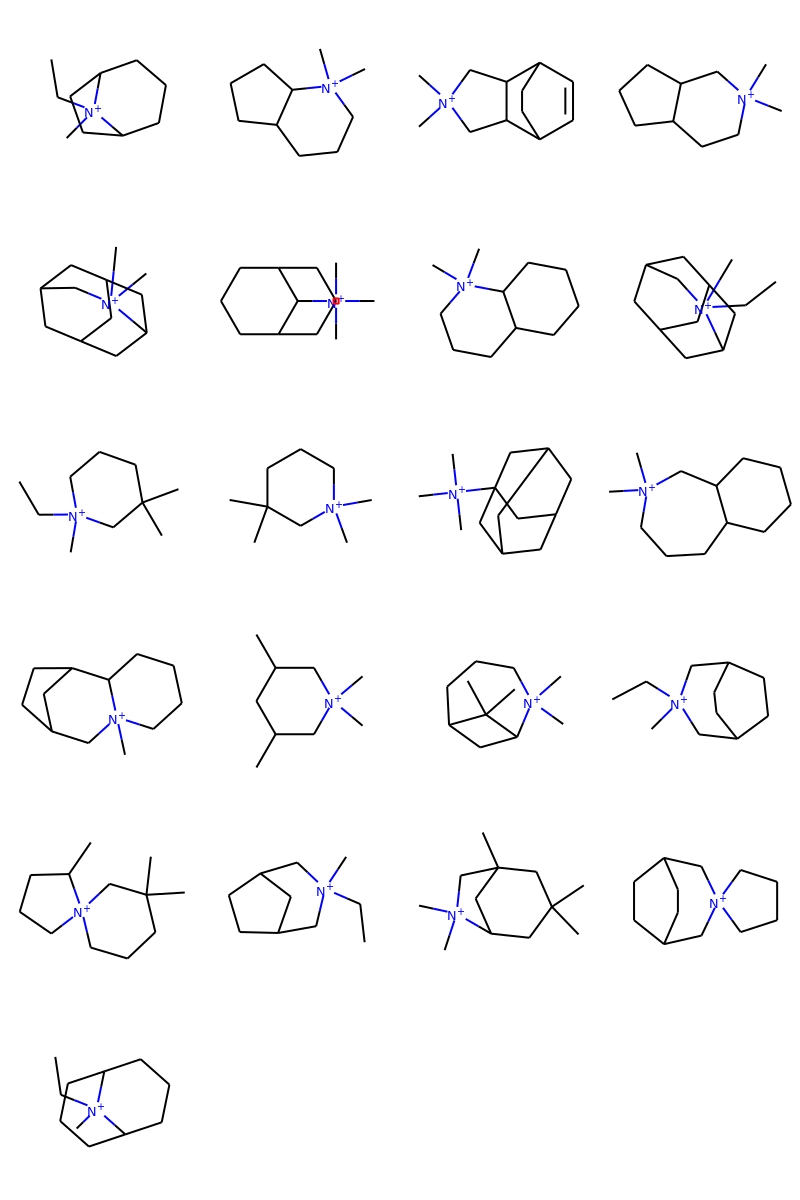

In [27]:
# Draw the OSDA molecules
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in smiles], molsPerRow=4)